# Introduction to Machine Learning

<img src="https://github.com/jeremiedecock/polytechnique-cse204-2018/blob/master/logo.jpg?raw=1" style="float: left; width: 15%" />

[CSE204-2018](https://moodle.polytechnique.fr/course/view.php?id=6784) Lab session #04

Jérémie DECOCK

<a href="https://colab.research.google.com/github/jeremiedecock/polytechnique-cse204-2018/blob/master/lab_session_04.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>

<a href="https://mybinder.org/v2/gh/jeremiedecock/polytechnique-cse204-2018/master?filepath=lab_session_04.ipynb"><img align="left" src="https://mybinder.org/badge.svg" alt="Open in Binder" title="Open and Execute in Binder"></a>

## Objectives

In the previous lab session, we have used a **parametric models** to solve **regression problems**.
Today you will continue the exploration of regression methods (both parametric and non-parametric).

- Kernel regression
- Weighted Least Squares
- Local Linear Regression
- Pathological cases
- Regularization with Ridge regression

**Note**: there are some differences in notations with the lecture slides. For instance, parameters are noted $w$ in lectures but they are noted $\theta$ here.

## Imports and tool functions

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
import sklearn.linear_model
import sklearn.pipeline
import sklearn.preprocessing

In [2]:
def gen_1d_polynomial_regression_samples(n_samples = 15):

    #x = np.random.uniform(low=0., high=10., size=n_samples)
    x = np.random.uniform(low=0., high=1.5, size=n_samples)

    #y = 3. - 2. * x + x ** 2 - x ** 3 + np.random.normal(scale=10., size=x.shape)
    y = np.cos(2. * np.pi * x) + np.random.normal(scale=0.1, size=x.shape)

    df = pd.DataFrame(np.array([x, y]).T, columns=['x', 'y'])

    df = sklearn.utils.shuffle(df).reset_index(drop=True)

    return df

In [3]:
def plot_1d_regression_samples(dataframe, model=None):
    fig, ax = plt.subplots(figsize=(8, 8))
    
    df = dataframe  # make an alias
    
    ERROR_MSG1 = "The `dataframe` parameter should be a Pandas DataFrame having the following columns: ['x', 'y']"
    assert df.columns.values.tolist() == ['x', 'y'], ERROR_MSG1
    
    if model is not None:
        
        # Compute the model's prediction
        
        x_pred = np.linspace(df.x.min(), df.x.max(), 100).reshape(-1, 1)
        y_pred = model.predict(x_pred)
        
        df_pred = pd.DataFrame(np.array([x_pred.flatten(), y_pred.flatten()]).T, columns=['x', 'y'])
        
        df_pred.plot(x='x', y='y', style='r--', ax=ax)

    # Plot also the training points
    
    df.plot.scatter(x='x', y='y', ax=ax)
    
    delta_y = df.y.max() - df.y.min()
    
    plt.ylim((df.y.min() - 0.15 * delta_y,
              df.y.max() + 0.15 * delta_y))

In [4]:
def plot_regression_1d(X, y, theta=None, x_min=0, x_max=2):
    assert X.ndim == 2 and X.shape[1] == 2, X.shape
    assert y.ndim == 2 and y.shape[1] == 1, y.shape
    if theta is not None:
        assert theta.ndim == 2 and theta.shape == (2, 1), theta.shape
    
    fig, ax = plt.subplots()
    ax.scatter(X[:,1], y)

    if theta is not None:
        x = np.linspace(x_min, x_max, 50)
        y = theta[0] + theta[1] * x

        ax.plot(x, y, "--r")

## Nadaraya-Watson Kernel Regression

Like k-Nearest Neighbors, *Nadaraya-Watson kernel regression* is a non-parametric model, i.e. decisions are made according to known examples from the *learning set* $\mathcal{D} = \{(y^{(i)}, \boldsymbol{x^{(i)}})\}_{1 \leq i \leq n}$ of $n$ examples and considering a kind of proximity relationship.

With k-Nearest Neighbors, decisions are based only on the closest neighbors and others examples are simply ignored.
On the contrary, with Kernel Regression all examples $(\boldsymbol{x}^{(i)}, y^{(i)})$ from $\mathcal{D}$ are used to predict the label $y$ of any new point $\boldsymbol{x}$: the contribution of $(\boldsymbol{x}^{(i)}, y^{(i)})$ in this prediction is weighted using a *kernel function* $K(\boldsymbol{x}^{(i)}, \boldsymbol{x})$. 

$$
y
= f(\boldsymbol{x})
= \frac{\sum^{n}_{i=1} K(\boldsymbol{x}^{(i)}, \boldsymbol{x}) ~ y^{(i)}}{\sum^{n}_{j=1} K(\boldsymbol{x}^{(j)}, \boldsymbol{x})}
= \sum^{n}_{i=1} y^{(i)} \omega^{(i)}
$$

with $\sum^{n}_{i=1} \omega^{(i)} = 1$

Recall about the notation used here:
- $\boldsymbol{x}^{(i)}$ is the feature (input) vector of the $i^{\text{th}}$ example in $\mathcal{D}$ (and $y^{(i)}$ is its label). Here, $\boldsymbol{x}^{(i)}$ is not the $i^{\text{th}}$ power of $\boldsymbol{x}$ (we will write $\boldsymbol{x}^{(i)2}$ for the square of $\boldsymbol{x}^{(i)}$)!
- $\boldsymbol{x}_i$ is the value of $\boldsymbol{x}$ on the $i^{\text{th}}$ dimension

### Exercise 1

#### Question 1

Implement the Gaussian kernel $K$ in the following `gaussian_kernel()` Python function.

$$
K(\boldsymbol{u}, \boldsymbol{v})
= \exp\left(\frac{-||\boldsymbol{u} - \boldsymbol{v}||^2_2}{2 \sigma^2} \right)
$$

where $\sigma$ is a parameter equals to $1$ by default.

You can assume $u$ and $v$ to be simple scalars to simplify this Python implementation (i.e. restrict yourself to regression problem with 1 dimension inputs $x \in \mathbb{R}$).

Recall: $e^x$ is written `math.exp(x)` in Python.

In [5]:
def gaussian_kernel(u, v, sigma = 1.):
    
    # TODO
    return math.exp((-(abs(u-v))**2)/(2*sigma**2))
   # TODO

#### Question 2

Implement the Nadaraya-Watson kernel regression in the following `kernel_regression()` Python function.

$$
\text{kernel_regression}(\boldsymbol{x}, \mathcal{D})
= \frac{\sum^{n}_{i=1} K(\boldsymbol{x}^{(i)}, \boldsymbol{x}) ~ y^{(i)}}{\sum^{n}_{i=1} K(\boldsymbol{x}^{(j)}, \boldsymbol{x})}
= y
$$

You can assume $x$ to be a simple scalar to simplify the Python implementation.
We assume `dataset` to contain examples $(\boldsymbol{x}^{(i)}, y^{(i)})$ of $\mathcal{D}$. Here, we assume `dataset` is a Pandas DataFrame having:
- one row per example
- a column "x" containing examples feature (only one dimension here)
- a column "y" containing examples label

**Hint**: you can use the following `for` loop to compute $\sum K(\boldsymbol{x}^{(i)}, \boldsymbol{x}) ~ y^{(i)}$: `for xi, yi in zip(df.x, df.y)`.

In [6]:
def kernel_regression(x, dataset):
    df = dataset
    # TODO
    return sum([gaussian_kernel(xi,x)*yi for xi,yi in zip(df.x,df.y)])/sum([gaussian_kernel(xi,x) for xi in df.x])
    


#### Question 3

We have the following dataset:

In [7]:
dataset = pd.DataFrame([[2., 0.],
                        [5., 2.],
                        [7., 1.],
                        [10., 2.],
                        [14., 4.],
                        [16., 3.],
                        [17., 0.]], columns=['x', 'y'])
dataset

x    y
0   2.0  0.0
1   5.0  2.0
2   7.0  1.0
3  10.0  2.0
4  14.0  4.0
5  16.0  3.0
6  17.0  0.0

Check your `kernel_regression()` function with the following code:

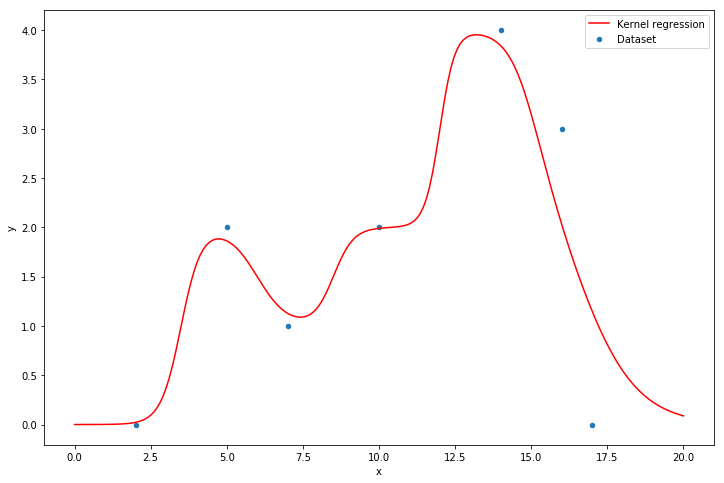

In [8]:
x_pred = np.linspace(0., 20., 200)
y_pred = [kernel_regression(x, dataset) for x in x_pred]

ax = dataset.plot.scatter(x='x', y='y', label="Dataset", figsize=(12,8))
ax.plot(x_pred, y_pred, "-r", label="Kernel regression")
plt.legend();

## *Weighted Least Squares*

For some regression problems, it may be helpful to give different importance to examples in the *learning set* $\mathcal{D} = \{(y^{(i)}, \boldsymbol{x^{(i)}})\}_{1 \leq i \leq n}$ that is to say associate a weight $\omega^{(i)}$ to example $\boldsymbol{x}^{(i)}$ in order to prioritize some of them and ignore some others (e.g. outliers).

Introducing these weights in the method of Least Square, the regression problem becomes:

$$E(\boldsymbol{\theta}) = \sum_{i=1}^n \omega^{(i)} (y^{(i)} - \boldsymbol{x}^{(i)} \boldsymbol{\theta})^2$$

In order to use the matrix notation, we put weights $\omega_i$ in the diagonal of the following matrix $\Omega$:

$$
\Omega =
\begin{pmatrix}
\omega^{(1)} & 0            & \cdots & 0 \\
0            & \omega^{(2)} & \cdots & 0 \\
\vdots       & \vdots       & \ddots & \vdots \\
0            & 0            & \cdots & \omega^{(n)} \\
\end{pmatrix}
$$

Then we can write:

$$E(\boldsymbol{\theta}) = (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})^T \Omega (\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta})$$

with:
$$
\boldsymbol{X} = \begin{pmatrix} 1 & x_1^{(1)} & \dots & x_p^{(1)} \\ \vdots & \vdots & \dots & \vdots \\ 1 & x_1^{(n)} & \dots & x_p^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{y} = \begin{pmatrix} y^{(1)} \\ \vdots \\ y^{(n)} \end{pmatrix}
\quad \quad
\boldsymbol{\theta} = \begin{pmatrix} \theta_0 \\ \vdots \\ \theta_p \end{pmatrix}
$$

### Exercise 2

#### Question 1

On a sheet of paper:
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta^*}$

#### Question 2

Is it a convexe optimization problem like *Ordinary Least Squares* ?

It is still a minimization problem.

#### Question 3

We have the following dataset and weights:

In [119]:
X = np.array([[1, 1],
              [1, 2],
              [1, 3],
              [1, 4],
              [1, 5]])

y = np.array([1.8, 4.5, 3.4, 3.6, 4.2]).reshape([-1, 1])

Omega = np.diag([1, 2, 3, 2, 1])

In [120]:
X

array([[1, 1],
       [1, 2],
       [1, 3],
       [1, 4],
       [1, 5]])

In [121]:
y

array([[1.8],
       [4.5],
       [3.4],
       [3.6],
       [4.2]])

In [122]:
Omega

array([[1, 0, 0, 0, 0],
       [0, 2, 0, 0, 0],
       [0, 0, 3, 0, 0],
       [0, 0, 0, 2, 0],
       [0, 0, 0, 0, 1]])

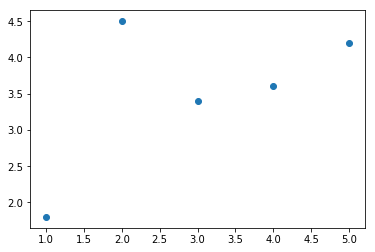

In [123]:
plt.scatter(X[:,1], y);

Complete the following Python implementation of the `weighted_least_squares()` procedure.
It should return the optimal parameter $\boldsymbol{\theta^*}$ using the method of Least Square for the matrix of weights $\Omega$.

In [124]:
def weighted_least_squares(X, Omega, y):
    X = np.matrix(X)
    Omega = np.matrix(Omega)
    y = np.matrix(y)
    # TODO
    invs = np.linalg.inv(np.dot(np.dot(X.T,Omega),X))
    form = np.dot(np.dot(X.T,Omega),y)

    
    return np.array(np.dot(invs,form))

In [125]:
theta = weighted_least_squares(X, Omega, y)
theta

array([[2.85],
       [0.25]])

Here, we expect $\theta$ to be a Numpy array of shape `(1, 2)` (i.e. a vector of two elements).

Numpy recall:
- The transpose of a matrix `X` is obtained with `X.T`
- The inverse of a matrix `X` is obtained with `np.linalg.inv(X)`
- The product of two matrices `X` and `Y` is obtained with `np.dot(X, Y)`
- The dot product of a matrix `X` and a vector `y` is obtained with `np.dot(X, y)`

#### Question 4

Check graphically your model using the following code:

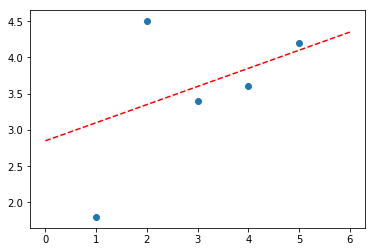

In [126]:
plot_regression_1d(X, y, theta, x_min=0, x_max=6)

#### Question 5

Change the weights in $\Omega$ to ignore the second point $x = 2$ (give the same weight to all other points) then recompute $\theta$ using `weighted_least_squares()` and check the results on plots with `plot_regression_1d()`.

## *Local Linear Regression*

Another possible usage of *Weighted Least Squares* is the *Local Linear Regression*. It uses a *Kernel* $K(\boldsymbol{x}^{(i)}, \boldsymbol{x})$ to define the weight $\omega^{(i)}$ assigned to example $i$. Thus it's a linear regression giving more importance to examples close to the point $\boldsymbol{x}$ to predict. This mean that this method does a new fit (in other words it computes a new $\boldsymbol{\theta}^*$) for each new point to predict!

For each point $\boldsymbol{x}$ to predict:
1. Compute weights $\omega^{(i)}$ assigned to examples $\boldsymbol{x}^{(i)}$ w.r.t their distance to $\boldsymbol{x}$: $\omega^{(i)} = K(\boldsymbol{x}^{(i)}, \boldsymbol{x})$
2. Fit Weighted Least Squares to obtain the $\boldsymbol{\theta}^*$ vector associated to $\boldsymbol{x}$
3. Return the prediction $y = \boldsymbol{x\theta}^*$

### Exercise 3

We have the following dataset:

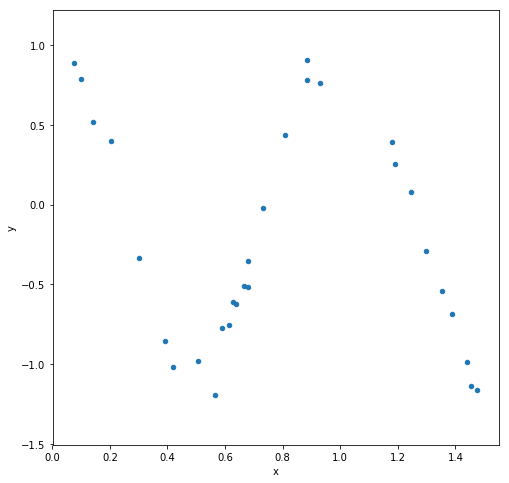

In [22]:
dataset = gen_1d_polynomial_regression_samples(n_samples=30)

plot_1d_regression_samples(dataset)

#### Question 1

Complete the following Python implementation of the `locally_weighted_regression()` procedure defined above.
It should use the previously implemented `gaussian_kernel()` function (with `sigma=0.1`) and `weighted_least_squares()` function. It should return the predicted label $y$ corresponding to the input $\boldsymbol{x}$.

In [96]:
def locally_weighted_regression(x, dataset, sigma=0.1):
    df = dataset   # Make an alias
    
    # Compute a weight wi for each example xi of the dataset: the closer xi is to x, the smaller wi is
    
    wi = np.array([gaussian_kernel(xi,x,sigma) for xi in df.x])         # <- **TODO: UNCOMMENT AND COMPLETE**

    Omega = [[0]*len(wi) for i in range(len(wi))]# <- **TODO: UNCOMMENT AND COMPLETE**
    for i in range(len(wi)):
        for j in range(len(wi)):
            if i == j: Omega[i][i] = wi[i]

    # Fit weighted least squares to obtain theta ##
    
    intercept = np.ones(shape=len(df.x))
    X = np.array([intercept, df.x]).T
    y = df.y.values.reshape([-1, 1])
    theta = weighted_least_squares(X, Omega, y)   # <- **TODO: UNCOMMENT**
    x = np.array([1,x])

    # Return prediction y = f(x) ##################
    return np.dot(x,theta)

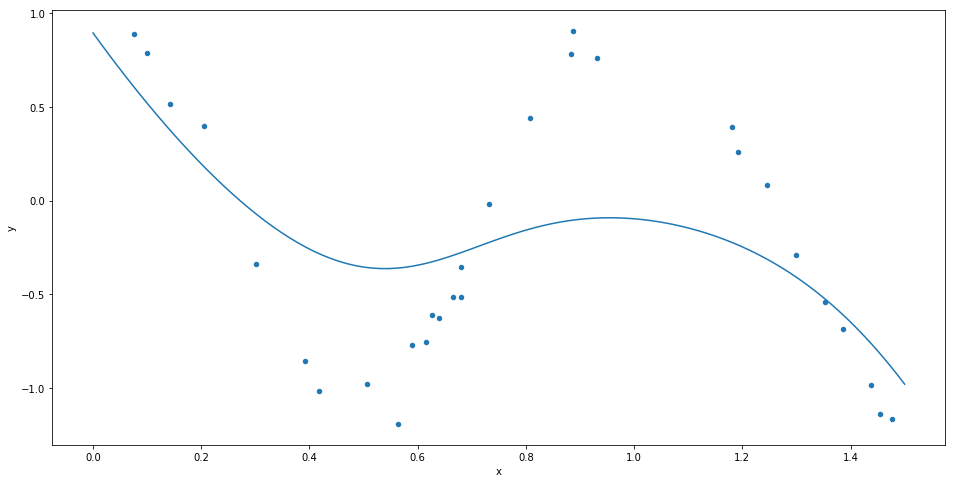

In [98]:
x_pred = np.linspace(0., 1.5, 100)
y_pred = [locally_weighted_regression(x, dataset, sigma=0.3) for x in x_pred]

ax = dataset.plot.scatter(x='x', y='y', figsize=(16, 8))

ax.plot(x_pred, y_pred)

#### Question 2

What happen when you change the value of the variable `sigma` parameter (try e.g. `sigma=0.3`)?
Why?

#### Question 3

Can we use Local Linear Regression to forecast time series as it was asked in the exercise 7 of the last tutorial? Why?

In [99]:
try:
    URL = "natural_gas_co2_emissions_for_electric_power_sector.csv"
    df = pd.read_csv(URL, parse_dates=[0])
except Exception:
    URL = "https://raw.githubusercontent.com/jeremiedecock/polytechnique-cse204-2018/master/natural_gas_co2_emissions_for_electric_power_sector.csv"
    df = pd.read_csv(URL, parse_dates=[0])

df['x'] = df.index
df['y'] = df.co2_emissions

df[['x','y']].head()

x       y
0  0  12.175
1  1  11.708
2  2  13.994
3  3  14.627
4  4  17.344

## Pathological cases

Consider the following implementation of the least squares method:

In [33]:
def least_squares(X, y):
    XX = np.dot(X.T, X)
    Xy = np.dot(X.T, y)
    invXX = np.linalg.inv(XX)

    theta = np.dot(invXX, Xy)
    
    return theta

We want to use it to apply linear regularization to some datasets.

### Exercise 4

#### Question 1

What is wrong with the following dataset ?

In [34]:
X = np.array([[1, 1.1, 2],
              [2, 2.2, 4]])
y = np.array([1.8, 2.7])

X

array([[1. , 1.1, 2. ],
       [2. , 2.2, 4. ]])

In [35]:
theta = least_squares(X, y)   # <- **TODO: UNCOMMENT**
theta                         # <- **TODO: UNCOMMENT**

LinAlgError: Singular matrix

#### Question 2

What is wrong with the following dataset ?

In [102]:
X = np.array([[1, 2, 3, 4, 5], [2, 4, 6, 8, 10]]).T
y = np.array([1.8, 2.7, 3.4, 3.8, 3.9])

In [103]:
theta = least_squares(X, y)   # <- **TODO: UNCOMMENT**
theta                         # <- **TODO: UNCOMMENT**

LinAlgError: Singular matrix

## Regularization with Ridge regression

We have the following dataset:

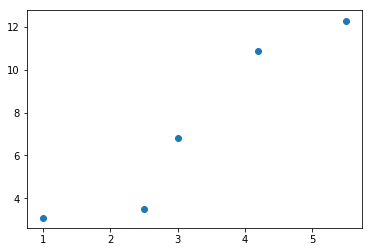

In [104]:
x = np.array([1, 2.5, 3, 4.2, 5.5])
y = np.array([3.1, 3.5, 6.8, 10.9, 12.3])

plt.scatter(x, y);

We apply basis expansion to fit a polynomial model on the data.

Coefs: [ 2.30283447  1.52730919  0.36067782 -0.86228428 -0.99030393  0.99827123
 -0.25707879  0.02057428]


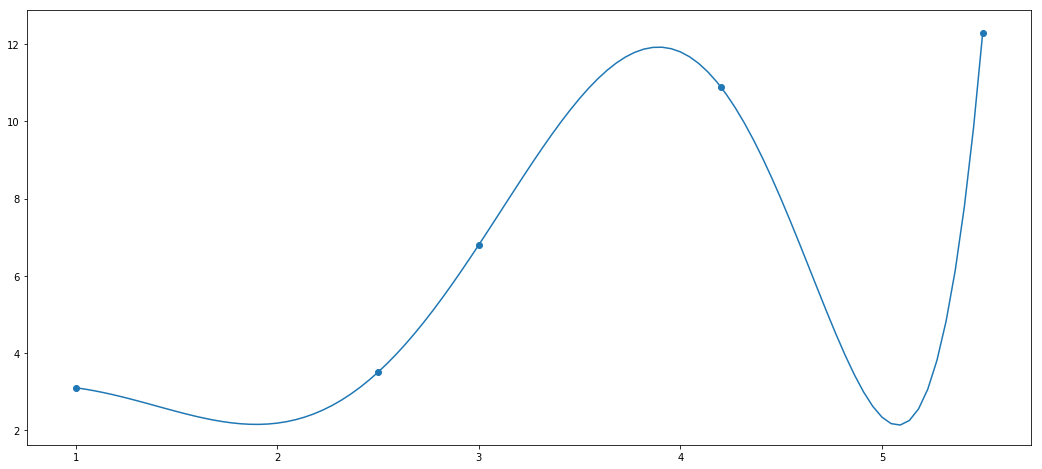

In [105]:
def basis_expansion(x, degree=5):
    Z_list = [np.ones(shape=x.shape)]   # intercept
    
    for deg_index in range(1, degree + 1):
        Z_list.append(x**deg_index)
    
    return np.array(Z_list).T

DEGREE = 7

Z = basis_expansion(x, degree=DEGREE)

# Make and fit the model

model = sklearn.linear_model.LinearRegression(fit_intercept=False)
model.fit(Z, y)

print("Coefs:", model.coef_)

# Compute the model's prediction

x_pred = np.linspace(x.min(), x.max(), 100)
Z_pred = basis_expansion(x_pred, degree=DEGREE)
Z_pred

y_pred = model.predict(Z_pred)

# Plot prediction and training set

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(x_pred, y_pred)
ax.scatter(x, y)
plt.show();

As you can see, a polynomial function of degree 7 is certainly not adapter to fit efficiently these data. Here we have a clear over-fitting: the model is too complex for the data and it will have poor generalization performance (i.e. big error on new unknown data).

A solution is to reduce the complexity of the model using a lower polynomial degree.

An alternative is to apply a *regularization method* like the *ridge regularization* (a.k.a. *L2 regularization*) which applies a penalty on the value of $\theta$ to constrain it to be as small as possible.

A $\boldsymbol{\theta}$ with small elements usually make the model simpler and bring better generalization performances.

This L2 regularization is included in the least square method as follow:

$$
\boldsymbol{\theta}^*
\leftarrow \arg\min_{\boldsymbol{\theta}} E(\boldsymbol{\theta})
\quad \text{with} \quad
E(\boldsymbol{\theta})
= \underbrace{||\boldsymbol{y} - \boldsymbol{X} \boldsymbol{\theta}||^2_2}_{\text{error term}} ~~ + \underbrace{\lambda ||\boldsymbol{\theta}||^2_2}_{\text{regularization}}$$

where $\lambda \in \mathbb{R}^+$ is the *regularization strength* coefficient:
- when $\lambda$ goes to infinity, the regularization term dominates the error term (MSE) and the coefficients $\boldsymbol{\theta}$ tend to zero
- when $\lambda$ goes to 0, the regularization term loose in importance and eventually the regularization term is ignored
- $\lambda$ is a *meta parameter*
- the best $\lambda$ for a problem can be computed empirically or automatically (e.g. grid search)

### Exercise 5

#### Question 1

On a sheet of paper:
- Compute the analytic formulation of the gradient $\nabla_{\boldsymbol{\theta}} E(\boldsymbol{\theta})$
- Compute the analytic formulation of the optimal parameter $\boldsymbol{\theta^*}$

#### Question 2

Is it a convexe optimization problem like *Ordinary Least Squares* ?

#### Question 3

Check the following Scikit Learn implementation of the Ridge Regression (more info here: https://scikit-learn.org/stable/modules/linear_model.html#ridge-regression ).

Coefs: [ 0.0044324   0.00671783  0.01211419  0.02333101  0.04080895  0.04706462
 -0.01892235  0.00169163]


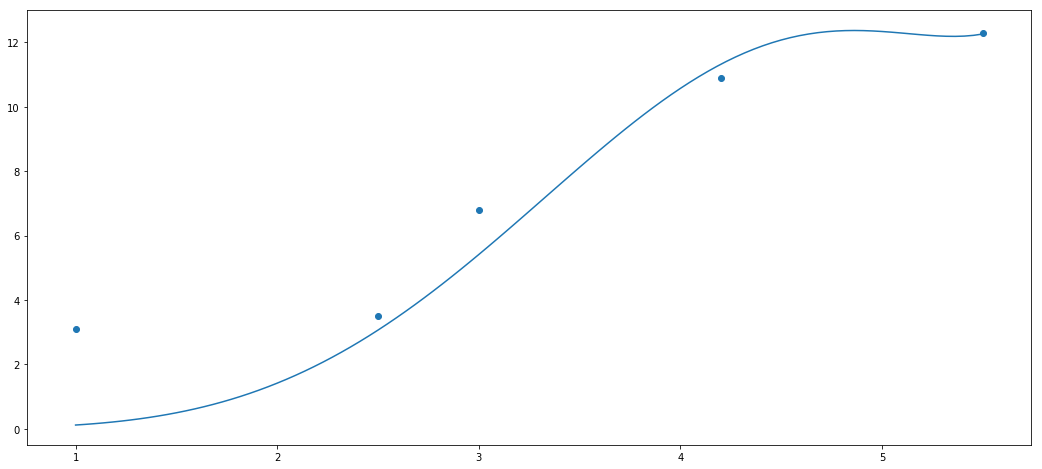

In [115]:
model = sklearn.linear_model.Ridge(alpha=1000, fit_intercept=False)

model.fit(Z, y)

coefs = [model.intercept_] + model.coef_

print("Coefs:", coefs)

# Compute the model's prediction

x_pred = np.linspace(x.min(), x.max(), 100)
Z_pred = basis_expansion(x_pred, degree=DEGREE)
Z_pred

y_pred = model.predict(Z_pred)

# Plot prediction and training set

fig, ax = plt.subplots(figsize=(18, 8))
ax.plot(x_pred, y_pred)
ax.scatter(x, y);
plt.show()

Change the value of the `alpha` parameter in `sklearn.linear_model.Ridge` and explain what happen (in Scikit Learn the $\lambda$ regression strength is named $\alpha$).

#### Question 4

Plot Ridge coefficients as a function of the regularization parameter.

Evaluate the following sequence of regularization strength: `alphas = np.logspace(-2, 5, 50)`.

In [ ]:
alphas = np.logspace(-2,5,50)


#### Question 5

Update the following function to implement the ridge regression in Python (without using Scikit Learn). Check it as in question 3.

In [39]:
def ridge_regression(X, y):
    XX = np.dot(X.T, X) - 
    Xy = np.dot(X.T, y)
    invXX = np.linalg.inv(XX)

    theta = np.dot(invXX, Xy)
    
    return theta